# Imports

In [2]:
## Import
import openseespy.opensees as ops
#import opsvis as opsv #For OpenSeesPy visualisation
#import matplotlib.pyplot as plt
#import opstool as opst
import ospgrillage as og


import math
import numpy as np
import pandas as pd


import os


# import logging
# logging.basicConfig(
#     level=logging.INFO,
#     #format="%(asctime)s %(levelname)s %(message)s",
#     #datefmt="%Y-%m-%d %H:%M:%S",
#     #filename="basic.log"

# )



# Fonctions utiles

In [3]:
def coordParallelogramme(x0,z0,a,b,angleBiais):
    """
    Revoi les coordonnées des 4 points : x1,z1,x2,z2,x3,z3,x4,z4
    :x1=x0
    :z1=z0
    """
    
    z1=round(z0,3)
    z2=round(z1,3)
    z3=round(z2+b,3)
    z4=round(z3,3)
    
    x1=round(x0,3)
    x2=round(x1+a,3)
    x3=round(x2+z3 / math.tan(math.radians(angleBiais)),3) if angleBiais != 0 else x2
    x4=round(x3-a,3)

    return x1,z1,x2,z2,x3,z3,x4,z4


In [4]:
def creerVehicule(vehicule_proprietes):
    """
    vehicule_proprietes: dictionnaire contenant les proprietés du vehicule
    'nom': nom de la charge
    'f':  liste des forces de chaque essieu
    'a':  liste des largeurs des roues par essieux  dans la direction x
    'b':  liste des largeurs des roues par essieux  dans la direction z
    'x':  liste des espacements entre essieux n et n-1 avec la premiere valeur toujours egale à 0 pour signifer le point de depart dans la direction x
    'z':  liste des espacements entre roues (ou groupe de roues) n et n-1 avec la premiere valeur toujours egale à 0 pour signifer le point de depart dans la direction z
    'al': coef d'ajustement de la charge
    'ad': coef de ponderation dynamique
    'ag': coef d'mperfection geometrique
    """
    chargePositionsX=[sum(vehicule_proprietes['x'][:i+1]) for i in range(len(vehicule_proprietes['x']))] #somme cumulative. Somme realisée sur chaque slice
    chargePositionsZ=[sum(vehicule_proprietes['z'][:i+1])-sum(vehicule_proprietes['z'])/2 for i in range(len(vehicule_proprietes['z']))] #mettre le point 0 de Z à l'axe du vehicule

    largeur_a=vehicule_proprietes['a']
    largeur_b=vehicule_proprietes['b']
    
    nbrRoue=len(chargePositionsZ) 

    force=[0.0 for _ in range(len(vehicule_proprietes['f']))] # astuce list contenant de zero avec la meme taille que vehicule_proprietes['f']
    
    if len(force)==len(largeur_a) and len(force)==len(largeur_b):
        for i in range(len(force)):
            force[i]= vehicule_proprietes['f'][i]/(nbrRoue*largeur_a[i]*largeur_b[i])
    else:
        raise Exception(f"Attention! Les listes f,a et b doivent avoir le meme nombre d'elements.\n"
                        f"longueur f = {len(force)}, longueur a = {len(largeur_a)}, longueur b = {len(largeur_b)}")
    
    vehicule = og.create_compound_load(name=vehicule_proprietes['nom'])
    

    for i in range(len(chargePositionsX)):
        for j in range(len(chargePositionsZ)):
            a1=largeur_a[i]
            b1=largeur_b[i]
            z0=chargePositionsZ[j]-b1/2
            x0=chargePositionsX[i]
            x1,z1,x2,z2,x3,z3,x4,z4=coordParallelogramme(x0,z0,a1,b1,0)
        
            chargeMag = force[i]*vehicule_proprietes['al']
            patch_vertex_1 = og.create_load_vertex(x=x1, z=z1, p=chargeMag)
            patch_vertex_2 = og.create_load_vertex(x=x2, z=z2, p=chargeMag)
            patch_vertex_3 = og.create_load_vertex(x=x3, z=z3, p=chargeMag)
            patch_vertex_4 = og.create_load_vertex(x=x4, z=z4, p=chargeMag)
        
            chargeSurfacique = og.create_load(
                loadtype="patch",
                #name="charge Surfacique",
                point1=patch_vertex_1,
                point2=patch_vertex_2,
                point3=patch_vertex_3,
                point4=patch_vertex_4,
            )

            #print(x1,z1,x2,z2,x3,z3,x4,z4)
    
            vehicule.add_load(load_obj=chargeSurfacique)

    return vehicule    


In [5]:
def creerItineraire(vehicule_proprietes,voie,decalage,pas_vehicule,niveauTablier,longueurTablier, largeurTablier ,largeurTrottoirDroite,largeurTrottoirGauche):
    """
    vehicule_proprietes: dictionnaire contenant les proprietés du vehicule
    voie = nom de la voie sur une liste (chaine de caracteres) : v1,v2,v3,axe
    decalage = decalage transveral de l'axe du vehicule par rapport à l'axe de la voie.Pertinent pour LM2 et LM3.Le sens positif va de droite vers la gauche 
    pas_vehicule = pas de deplacement du vehicule
    Les autres parametres sont ceux du modeles :
        :niveauTablier
        :longueurTablier
        :largeurTablier 
        :largeurTrottoirDroite
        :largeurTrottoirGauche
    """
    
    x1 = -( sum(vehicule_proprietes['x']) + vehicule_proprietes['a'][0]/2 + vehicule_proprietes['a'][-1]/2 ) #longueur du vehicule avant tablier
    x2 = longueurTablier # - x1 # si besoin (-x1) permet d'ajouter une longueur du vehicule apres tablier
    voie_p1 = og.create_point(x=x1,y=niveauTablier,z=0) # initilisation
    voie_p2 = og.create_point(x=x2,y=niveauTablier,z=0)
    
    if (voie=="v1"):
        voie_p1 = og.create_point(x=x1,y=niveauTablier,z=largeurTrottoirDroite + decalage + 1.5)
        voie_p2 = og.create_point(x=x2,y=niveauTablier,z=largeurTrottoirDroite + decalage + 1.5) #voie_p2 = og.Point(longueurTablier,0,0) # selection d'un point existant
    elif (voie=="v2"): 
        voie_p1 = og.create_point(x=x1,y=niveauTablier,z=largeurTrottoirDroite + decalage + 3 + 1.5)
        voie_p2 = og.create_point(x=x2,y=niveauTablier,z=largeurTrottoirDroite + decalage + 3 + 1.5) 
    elif (voie=="v3"): 
        voie_p1 = og.create_point(x=x1,y=niveauTablier,z=largeurTrottoirDroite + decalage + 3*2 + 1.5)
        voie_p2 = og.create_point(x=x2,y=niveauTablier,z=largeurTrottoirDroite + decalage + 3*2 + 1.5) 
    elif (voie=="axe"): 
        voie_p1 = og.create_point(x=x1,y=niveauTablier,z=(largeurTablier - largeurTrottoirDroite - largeurTrottoirGauche)/2 + largeurTrottoirDroite + decalage)
        voie_p2 = og.create_point(x=x2,y=niveauTablier,z=(largeurTablier - largeurTrottoirDroite - largeurTrottoirGauche)/2 + largeurTrottoirDroite + decalage) 
    else:
        raise Exception("Attention, la voie doit etre soit 'standard' soit 'axe'")    

    voie = og.create_moving_path(start_point=voie_p1, end_point= voie_p2,increments= int(1+(x2-x1)//pas_vehicule))

    return voie

In [6]:

def get_nodes_by_ele_tags(element_tags):
    # List to store unique nodes and their coordinates
    node_data = []
    unique_nodes = set()  # Track processed nodes to avoid duplicates
    
    # Loop through each element to retrieve its nodes
    for element in element_tags:
        # Get node tags for the element
        node_tags = ops.eleNodes(element)
        for node in node_tags:
            if node not in unique_nodes:  # Avoid duplicates
                coords = ops.nodeCoord(node)  # Get x, y, z coordinates
                node_data.append([node, *coords])  # Add node tag and coordinates
                unique_nodes.add(node)  # Mark node as processed
    
    # Convert to Pandas DataFrame
    df = pd.DataFrame(node_data, columns=["Node", "X", "Y", "Z"])
    
    return df

In [7]:
def add_row_to_df(df, new_row_dict):
    # Find the next available index (current length of the DataFrame)
    next_index = len(df)
    
    # Add the new row using .loc[] and a dictionary
    for key, value in new_row_dict.items():
        df.loc[next_index, key] = value

def definirChargeRoulante(vehicule,itineraire,load_case_data,**kwargs):
    # list_charge_roulante_noms=[]
    # for i in range(len(load_case_data)):
    #     list_charge_roulante_noms.append(list_charge_roulante[i].name)

    nom_charge=kwargs['name']

    # if nom_charge in list_charge_roulante_noms:
    if nom_charge in load_case_data.name:
    
        print("Un cas de charge mobile ayant le même nom existe déjà. Le doublon n'est pas rajouté.\n"
                "Etant donné qu'il n'est pas possible de supprimer un cas de charge dans openseespy + ospgrillage, \n"
                "il n'y a que 2 options si l'on veut avoir la nouvel charge :\n"
                "    - Modifier l'instruction et relancer le script depuis le debut \n"
                "    - Créer une charge avec un nom different"
                ) #il faut plutot remplacer avec le nouveau
    else:    
        vehicule_roulant = og.create_moving_load(name=nom_charge ) 
        vehicule_roulant.set_path(itineraire)
        vehicule_roulant.add_load(vehicule)
        model.add_load_case(vehicule_roulant)
        #add to list for later on
        # list_charge_roulante.append(vehicule_roulant) #moving load object
        # load_case_data = pd.concat([load_case_data, pd.DataFrame([kwargs])], ignore_index=True) #this create a copy so it's not suitable far a use in a function
        add_row_to_df(load_case_data,kwargs)
        


# #vehicule a un endroit fixe : Peut etre utile pour epreuve (voir pour en faire une fonction)
# TS1_lc = og.create_load_case(name="TS1 voie 1")

# TS1_v1 = creerVehicule(TS1)

# # Position in global coords
# TS1_v1.set_global_coord(TS1_itineraire.start_point) #og.Point(x_coord[0], 0, z_coord[0]))
# # And add to the load case with the lane factor
# TS1_lc.add_load(load_obj=TS1_v1) #,load_factor=TS1_v1['al'])

# # Now create the patch
# vertex_1 = og.create_load_vertex(x=-longueurTablier,  z=z_coord[0] - udl_width/2, p=udl_mag)
# vertex_2 = og.create_load_vertex(x=2*longueurTablier, z=z_coord[0] - udl_width/2, p=udl_mag)
# vertex_3 = og.create_load_vertex(x=2*longueurTablier, z=z_coord[0] + udl_width/2, p=udl_mag)
# vertex_4 = og.create_load_vertex(x=-longueurTablier,  z=z_coord[0] + udl_width/2, p=udl_mag)

# model.add_load_case(TS1_lc,load_factor=dla)




In [8]:
def get_forces_per_beam_per_lc(lc_result, **kwargs):
    """
    Process force components for all load cases starting with a given prefix.

    Parameters:
        lc_result: xarray dataset containing force results.
        kwargs: Dictionary of optional parameters:
            - load_case_name (str): Load case prefix to process (default: '').
            - member_name (str): Name of the member to process (default: '').
            - z_group_index (int): Index for the Z group (default: 0).
            - force_components (list): List of force components (default: ['Mz', 'Vy']).

    Returns:
        pd.DataFrame: Combined values with node tags and X coordinates for all matching load cases.
    """
    # Set defaults for optional parameters
    load_case_name = kwargs.get('load_case_name', '')
    member_name = kwargs.get('member_name', '')
    z_group_index = kwargs.get('z_group_index', 0)
    force_components = kwargs.get('force_components', ['Mz', 'Vy'])

    # Filter load cases starting with the given prefix
    matching_load_cases = [lc for lc in lc_result.Loadcase.to_numpy() if lc.startswith(load_case_name)] # trouver un moyen de distinger les charges roulante des autres : ' at' ajouté car ospgrillage ajoute la position de la charge mobile. Ceci les distingues des charges statiques

    # Get elements for the member
    poutre_elements = model.get_element(member=member_name, z_group_num=z_group_index, options="elements")

    # Prepare force component names for i and j
    force_component_i = [f"{component}_i" for component in force_components]
    force_component_j = [f"{component}_j" for component in force_components]

    # Initialize an empty DataFrame to store results
    all_results = pd.DataFrame()

    # Loop through each matching load case
    for lc in matching_load_cases:
        # Process i and j values
        i_values = np.round(
            lc_result.forces.sel(
                Loadcase=[lc], Component=force_component_i, Element=poutre_elements
            ).values.astype(np.float64) / 1000,
            2
        )

        j_values = -1 * np.round(
            lc_result.forces.sel(
                Loadcase=[lc], Component=force_component_j, Element=poutre_elements
            ).values.astype(np.float64)[:, -1] / 1000,
            2
        )

        # Reshape and concatenate
        j_values_reshaped = j_values.reshape(i_values.shape[0], 1, -1)
        combined_values = np.concatenate((i_values, j_values_reshaped), axis=1)

        # Get node tags and X coordinates
        poutre_nodes = get_nodes_by_ele_tags(poutre_elements)
        x_values = poutre_nodes.to_numpy()[:, :2]

        # Reshape x_values and concatenate along the third dimension
        x_values_reshaped = np.tile(x_values, (i_values.shape[0], 1, 1))
        combined_with_x = np.concatenate((x_values_reshaped, combined_values), axis=2)

        # Flatten the 3D array to 2D
        reshaped_array = combined_with_x.reshape(combined_with_x.shape[1], combined_with_x.shape[2])

        # Generate column names for the current load case
        column_names = ['Node', 'X_Coord'] + [f"{lc} : {comp}" for comp in force_components]

        # Create DataFrame for the current load case
        df = pd.DataFrame(reshaped_array, columns=column_names)

        # Append to the results DataFrame
        all_results = pd.concat([all_results, df], axis=1)
        # Remove duplicate columns
        all_results = all_results.loc[:, ~all_results.columns.duplicated()]  # Remove node and X_Coord duplicates

    if all_results.shape[1] > (2 + len(force_components)):
        envoloppe_results = all_results.iloc[:, :2].copy()
        num_component = len(force_components)

        for i in range(len(force_components)):
            envoloppe_results[f"{load_case_name} : {force_components[i]}_max"] = all_results.iloc[:, 2 + i::num_component].max(axis=1)

        for i in range(len(force_components)):
            envoloppe_results[f"{load_case_name} : {force_components[i]}_min"] = all_results.iloc[:, 2 + i::num_component].min(axis=1)

        return envoloppe_results

    else:
        return all_results


In [9]:
def get_forces_per_beam_per_comb(lc_result, **kwargs):
    """
    Process force components for all load cases starting with a given prefix.

    Parameters:
        comb_result: xarray dataset containing force results for 1 combination.
        kwargs: Dictionary of optional parameters:
            - member_name (str): Name of the member to process (default: '').
            - z_group_index (int): Index for the Z group (default: 0).
            - force_components (list): List of force components (default: ['Mz', 'Vy']).

    Returns:
        pd.DataFrame: Combined values with node tags and X coordinates for all matching load cases.
    """
    # Set defaults for optional parameters
    member_name = kwargs.get('member_name', '')
    z_group_index = kwargs.get('z_group_index', 0)
    force_components = kwargs.get('force_components', ['Mz', 'Vy'])

    # NOte :  this looks like the _lc function but there arent differences. This only takes one combination. Therefore,only 2D tables are used and no 3D tables.
       
       
       
        
    # Get elements for the member
    poutre_elements = model.get_element(member=member_name, z_group_num=z_group_index, options="elements")

    # Prepare force component names for i and j
    force_component_i = [f"{component}_i" for component in force_components]
    force_component_j = [f"{component}_j" for component in force_components]

    # Initialize an empty DataFrame to store results
    all_results = pd.DataFrame()

    
    # Process i and j values
    i_values = np.round(
        lc_result.forces.sel(
            Component=force_component_i, Element=poutre_elements
        ).values.astype(np.float64) / 1000,
        2
    )

    j_values = -1 * np.round(
        lc_result.forces.sel(
            Component=force_component_j, Element=poutre_elements
        ).values.astype(np.float64)[-1] / 1000,
        2
    )
    # j_values_reshaped = j_values.reshape(i_values.shape[0], 1, -1)
    j_values_reshaped = j_values.reshape( 1, -1)
    combined_values = np.concatenate((i_values, j_values_reshaped), axis=0)

    
    # Get node tags and X coordinates
    poutre_nodes = get_nodes_by_ele_tags(poutre_elements)
    x_values = poutre_nodes.to_numpy()[:, :2]

    # Reshape x_values and concatenate along the third dimension
    # x_values_reshaped = np.tile(x_values, (i_values.shape[0], 1, 1))
    x_values_reshaped = x_values
    
    combined_with_x = np.concatenate((x_values_reshaped, combined_values), axis=1)

    # Flatten the 3D array to 2D
    # reshaped_array = combined_with_x.reshape(combined_with_x.shape[1], combined_with_x.shape[2])
    reshaped_array = combined_with_x

    # Generate column names for the current load case
    column_names = ['Node', 'X_Coord'] + [f"combi: {comp}" for comp in force_components]

    # Create DataFrame for the current load case
    df = pd.DataFrame(reshaped_array, columns=column_names)

    # Append to the results DataFrame
    all_results = pd.concat([all_results, df], axis=1)
    # Remove duplicate columns
    all_results = all_results.loc[:, ~all_results.columns.duplicated()]  # Remove node and X_Coord duplicates
            
            
        
        
        
        
    
    # if all_results.shape[1] > (2 + len(force_components)):
    #     envoloppe_results = all_results.iloc[:, :2].copy()
    #     num_component = len(force_components)

    #     for i in range(len(force_components)):
    #         envoloppe_results[f"{load_case_name} : {force_components[i]}_max"] = all_results.iloc[:, 2 + i::num_component].max(axis=1)

    #     for i in range(len(force_components)):
    #         envoloppe_results[f"{load_case_name} : {force_components[i]}_min"] = all_results.iloc[:, 2 + i::num_component].min(axis=1)

    #     return envoloppe_results

    # else:
    #     return all_results
    
    return all_results


In [10]:
def get_forces_per_beam_per_comb_group(combis, **kwargs):
    """
    Compute the forces per beam for a group of combinations and extract the min/max values for specified force components.

    Parameters:
        combis (pd.DataFrame): 
            A DataFrame containing the combinations. Each row represents a combination, with the first column as 
            the combination identifier and the following columns as load values.

        kwargs (dict): 
            Additional parameters:
            - member_name (str): 
                The name of the structural member for which forces are computed. Defaults to an empty string.
            - z_group_index (int): 
                The index of the Z group used to filter elements. Defaults to 0.
            - force_components (list of str): 
                A list of force components to process (e.g., ['Mz', 'Vy']). Defaults to ['Mz', 'Vy'].

    Returns:
        pd.DataFrame: 
            A DataFrame containing the following:
            - Minimum and maximum values for each force component across combinations.
            - Combination labels for corresponding min/max values.
            If fewer than two combinations are provided, the results for each combination are returned directly.
    """
    
    # Set defaults for optional parameters
    member_name = kwargs.get('member_name', '')
    z_group_index = kwargs.get('z_group_index', 0)
    force_components = kwargs.get('force_components', ['Mz', 'Vy'])

    all_results = pd.DataFrame()

    # Loop through combinations
    for _, combi in combis.iterrows():
        # Filter non-zero, non-NaN values from the combination
        combi_i = {k: v for k, v in combi[1:].to_dict().items() if pd.notna(v) and v != 0}

        # Get elements for the member
        poutre_elements = model.get_element(member=member_name, z_group_num=z_group_index, options="elements")

        # Get results for the combination
        combination_results = model.get_results(combinations=combi_i)

        # Process forces for the current combination
        combined_values = get_forces_per_beam_per_comb(
            combination_results, 
            member_name=member_name, 
            z_group_index=z_group_index, 
            force_components=force_components
        )

        # Append the current combination results to the aggregated DataFrame
        all_results = pd.concat([all_results, combined_values], axis=1)#,ignore_index=True)
        
    
    if all_results.shape[1] > (2 + len(force_components)):
        envoloppe_results = all_results.iloc[:, :2].copy()
        num_component = len(force_components)

        for i in range(len(force_components)):
            envoloppe_results[f"combi : {force_components[i]}_max"] = all_results.iloc[:, 2 + i::num_component].max(axis=1)

        for i in range(len(force_components)):
            envoloppe_results[f"combi : {force_components[i]}_min"] = all_results.iloc[:, 2 + i::num_component].min(axis=1)

        return envoloppe_results

    else:
        return all_results



# Parametrages

In [11]:
#Paramtratage de l'affichage graphique

og.plt.rcParams['figure.figsize'] = [8, 4.5]
%matplotlib inline

#Parametrage d'unités
kilo = 1e3
milli = 1e-3
N = 1
m = 1
mm = milli * m
m2 = m ** 2
m3 = m ** 3
m4 = m ** 4
kN = kilo * N
Pa = 1
MPa = N / ((mm) ** 2)
GPa = kilo * MPa
kPa = kilo * Pa

# Données d'entrées

In [12]:
#Geometrie du tablier
longueurTravee = 33.5 * m  # verifer coef_pond_dyn lorsque ceci sera une liste (multi travée) # verifier chargement du poids prpre des entretoises
longueurTablier = longueurTravee 
largeurTablier = 11.565 * m                
nPoutres = 7                       # number of longitudinal members
nBarresHourdis = 11                      # number of transverse members
distPLoPRi = 1.05 * m          # distance between edge beam and first exterior beam # privilegier la rivedu tablier au lieu de l'xe de la poutre longrine
distPRiPCo1 = 2.2775 * m  # distance between first exterior beam and first interior beam
angleBiais = 0                    #angles biais par rapport à l'axe perpendiculaire à la longeur de l'ouvrage. si plusieurs biais par entretoise,corriger les valeurs des chargements Patchloads
niveauTablier = 0 # niveau du tablier par rapport au sol (a prendre egal à zero sauf cas des portiques : on verra au moment de developper un module pour les portiques


In [13]:
#Materiaux
#TAF: creer mes propres materiaux dans le fichier mat_lib.json avec les eurocodes. 
#Ou alors creer les materiaux directement dans le code avec la seconde declaration si je trouve comment integer le fck
betonPoutre = og.create_material(material="concrete", code="AS5100-2017", grade="65MPa") 
#betonPoutre = og.create_material(material="concrete",E=45*GPa, v= 0.2, rho=25*kN/m3 )
betonHourdis = og.create_material(material="concrete", code="AS5100-2017", grade="65MPa") 

# Densité (hors ospgrillage)
densiteBetonPoutre =24*kN*m3
densiteBetonHourdis =24*kN*m3
densiteEnrobe=24*kN*m3
densiteEtancheite=24*kN*m3


In [14]:
#Sections des poutres
sectionPoutreRive = og.create_section(
    A=0.934 * m2,
    J=0.1857 * m3,
    Iz=0.3478 * m4,
    Iy=0.213602 * m4,
    Az=0.444795 * m2,
    Ay=0.258704 * m2,
)

sectionPoutreCourante = og.create_section(
    A=1.025 * m2,
    J=0.1878 * m3,
    Iz=0.3694 * m4,
    Iy=0.3634 * m4,
    Az=0.4979 * m2,
    Ay=0.309 * m2,
)

sectionBarreHourdis = og.create_section(
    A=0.504 * m2,
    J=5.22303e-3 * m3,
    Iy=0.32928 * m4,
    Iz=1.3608e-3 * m4,
    Ay=0.42 * m2,
    Az=0.42 * m2,
    unit_width=True #je ne comprend pas ça
)

sectionPoutreEntretoise = og.create_section(
    A=0.504 / 2 * m2,
    J=2.5012e-3 * m3,
    Iy=0.04116 * m4,
    Iz=0.6804e-3 * m4,
    Ay=0.21 * m2,
    Az=0.21 * m2,
)

sectionPoutreBordure = og.create_section(
    A=0.934 * m2,
    J=0.1857 * m3,
    Iz=0.3478 * m4,
    Iy=0.213602 * m4,
    Az=0.444795 * m2,
    Ay=0.258704 * m2,
)

epaisseurHourdis=0.18*m
sectionHourdis = og.create_section(h=epaisseurHourdis)

In [15]:
#Superstructure

epaisseurEtancheite=0.03*m
coefEtancheiteMin=0.8
coefEtancheiteMax=1.4

epaisseurEnrobe=0.03*m
coefEnrobeMin=0.8
coefEnrobeMax=1.2

largeurTrottoirGauche=1*m
largeurTrottoirDroite=1*m
epaisseurTrottoirGauche=0.4*m
epaisseurTrottoirDroite=0.4*m
coefTrottoirMin=0.95
coefTrottoirMax=1.05

chargeLineaireDispositifRetenuGauche=6.54 * kN/m
positionDispositifRetenuGauche = 0.25*m
chargeLineaireDispositifRetenuDroite=6.54 * kN/m
positionDispositifRetenuDroite = 0.25*m
coefDispositifRetenuMin=0.9
coefDispositifRetenuMax=1.1


chargeLineaireGardeCorpsGauche=0 * kN/m
positionGardeCorpsGauche = 1*m
chargeLineaireGardeCorpsDroite=0 * kN/m
positionGardeCorpsDroite = 1*m
coefGardeCorpsMin=0.9
coefGardeCorpsMax=1.1


chargeLineaireEcranGauche=6.54 * kN/m
positionEcranGauche = 0.25*m
chargeLineaireEcranDroite=6.54 * kN/m
positionEcranDroite = 0.25*m
coefEcranMin=0.9
coefEcranMax=1.1

In [16]:
#charges variable
categorieTrafic=1


# Bibliotheque de vehicules

In [17]:
"""
unités :
f: KN
a,b,x,z: m
"""


if categorieTrafic==1:
    alpha_trafic_TS_v1=1
    alpha_trafic_UDL_v1=1

    alpha_trafic_TS_v2=1
    alpha_trafic_UDL_v2=1.2
    
    alpha_trafic_TS_v3=1
    alpha_trafic_UDL_v3=1.2
    
else:
    alpha_trafic_TS_v1=0.9
    alpha_trafic_UDL_v1=0.7

    alpha_trafic_TS_v2=0.8
    alpha_trafic_UDL_v2=1
    
    alpha_trafic_TS_v3=0.8
    alpha_trafic_UDL_v3=1
   
coef_pond_dyn= 1+0.7/(1+0.2*(longueurTravee))

#garder TS1 à 3 independent pour pouvour faire des cas de figure ou TS1 est au mileu par example
TS1_proprietes={
    'nom':"LM1-TS1",
    'f':  [300 ,300 ],
    'a':  [0.4 ,0.4 ],
    'b':  [0.4 ,0.4 ],
    'x':  [0   ,1.2 ],
    'z':  [0   ,2.0 ],
    'al': alpha_trafic_TS_v1,
    'ad': 1.0,
    'ag': 1.0
}
TS1=creerVehicule(TS1_proprietes)

TS2_proprietes={
    'nom':"LM1-TS2",
    'f':  [200 ,200 ],
    'a':  [0.4 ,0.4 ],
    'b':  [0.4 ,0.4 ],
    'x':  [0   ,1.2 ],
    'z':  [0   ,2.0 ],
    'al': alpha_trafic_TS_v2,
    'ad': 1.0,
    'ag': 1.0
}
TS2=creerVehicule(TS2_proprietes)

TS3_proprietes={
    'nom':"LM1-TS3",
    'f':  [100 ,100 ],
    'a':  [0.4 ,0.4 ],
    'b':  [0.4 ,0.4 ],
    'x':  [0   ,1.2 ],
    'z':  [0   ,2.0 ],
    'al': alpha_trafic_TS_v3,
    'ad': 1.0,
    'ag': 1.0
}
TS3=creerVehicule(TS3_proprietes)

LM2_proprietes={
    'nom':"LM2",
    'f':  [400  ],
    'a':  [0.35 ],
    'b':  [0.6  ],
    'x':  [0    ],
    'z':  [0   ,2.0 ],
    'al': 1.0,
    'ad': 1.0,
    'ag': 1.0
} 
LM2=creerVehicule(LM2_proprietes)

MC120_proprietes={
    'nom':"MC120",
    'f':  [1100  ],
    'a':  [6.10 ],
    'b':  [1.0  ],
    'x':  [0    ],
    'z':  [0 ,3.3 ],
    'al': 1.0,
    'ad': coef_pond_dyn,
    'ag': 1.0
}  
MC120=creerVehicule(MC120_proprietes)

TE120_proprietes={
    'nom':"TE120",
    'f':  [120 ,120 ,120 ,120 ,120 ,120 ,120 ,120 ,120 ,120 ],
    'a':  [0.4 ,0.4 ,0.4 ,0.4 ,0.4 ,0.4 ,0.4 ,0.4 ,0.4 ,0.4 ],
    'b':  [0.4 ,0.4 ,0.4 ,0.4 ,0.4 ,0.4 ,0.4 ,0.4 ,0.4 ,0.4 ],
    'x':  [0   ,1.35,1.35,1.35,1.35,1.35,1.35,1.35,1.35,1.35],
    'z':  [0   ,2.25],
    'al': 1.0,
    'ad': coef_pond_dyn,
    'ag': 1.1
}
TE120=creerVehicule(TE120_proprietes)

PEB_proprietes={
    'nom':"PEB",
    'f':  [79.90,128.975,128.975 ,98.55 ],
    'a':  [7    ,0.3    ,0.3     ,0.3   ],
    'b':  [0.535,0.75   ,0.75    ,0.31   ],
    'x':  [0    ,9.035  ,1.35    ,4.325 ],
    'z':  [0    ,2.652  ],
    'al': 1.0,
    'ad': coef_pond_dyn,
    'ag': 1.1
}
PEB=creerVehicule(PEB_proprietes)


C2_proprietes={
    'nom':"C2",
    'f':  [120 ,120 ,120 ,120 ,120 ,120 ,120 ,120 ,120 ,120 ],
    'a':  [0.4 ,0.4 ,0.4 ,0.4 ,0.4 ,0.4 ,0.4 ,0.4 ,0.4 ,0.4 ],
    'b':  [0.4 ,0.4 ,0.4 ,0.4 ,0.4 ,0.4 ,0.4 ,0.4 ,0.4 ,0.4 ],
    'x':  [0   ,1.35,1.35,1.35,1.35,1.35,1.35,5.07,1.35,3.20],
    'z':  [0   ,2.4 ],
    'al': 1.0,
    'ad': coef_pond_dyn,
    'ag': 1.1
}
C2=creerVehicule(C2_proprietes)

D2F1_proprietes={
    'nom':"D2F1",
    'f':  [2450 ],
    'a':  [21.7 ],
    'b':  [3.2  ],
    'x':  [0    ],
    'z':  [0    ],
    'al': 1.0,
    'ad': coef_pond_dyn,
    'ag': 1.1
}
D2F1=creerVehicule(D2F1_proprietes)

D3F1_proprietes={
    'nom':"D3F1",
    'f':  [2500 ],
    'a':  [17.05],
    'b':  [5.15 ],
    'x':  [0    ],
    'z':  [0    ],
    'al': 1.0,
    'ad': 1.0,
    'ag': 1.1
}
D3F1=creerVehicule(D3F1_proprietes)

D3F2_proprietes={
    'nom':"D3F1",
    'f':  [1250,1250],
    'a':  [9.3 ,9.3 ],
    'b':  [5.15,5.15],
    'x':  [0   ,24  ],
    'z':  [0    ],
    'al': 1.0,
    'ad': 1.0,
    'ag': 1.1
}
D3F2=creerVehicule(D3F2_proprietes)

E2F1_proprietes={
    'nom':"E2F1",
    'f':  [3500 ],
    'a':  [31   ],
    'b':  [3.2  ],
    'x':  [0    ],
    'z':  [0    ],
    'al': 1.0,
    'ad': 1.0,
    'ag': 1.1
}
E2F1=creerVehicule(E2F1_proprietes)

E3F1_proprietes={
    'nom':"E3F1",
    'f':  [4000 ],
    'a':  [26.35],
    'b':  [5.15 ],
    'x':  [0    ],
    'z':  [0    ],
    'al': 1.0,
    'ad': 1.0,
    'ag': 1.1
}
E3F1=creerVehicule(E3F1_proprietes)

E3F2_proprietes={
    'nom':"E3F1",
    'f':  [1880,1880 ],
    'a':  [12.4,12.4],
    'b':  [5.15,5.15],
    'x':  [0   ,24  ],
    'z':  [0    ],
    'al': 1.0,
    'ad': 1.0,
    'ag': 1.1
}
E3F2=creerVehicule(E3F2_proprietes)

# Definition du Grillage

In [18]:
#Element du grillage
poutreCourante = og.create_member(section=sectionPoutreCourante, material=betonPoutre)
poutreRive = og.create_member(section=sectionPoutreRive, material=betonPoutre)
barreHourdis = og.create_member(section=sectionBarreHourdis, material=betonHourdis)
poutreEntretoise = og.create_member(section=sectionPoutreEntretoise, material=betonHourdis)
# poutreBordure = og.create_member(section=sectionPoutreBordure, material=betonPoutre)

In [19]:
#Creation du grillage #model est une instance de la classe OspGrillage
model = og.create_grillage(
    bridge_name="Pont_test",
    long_dim=longueurTravee,
    width=largeurTablier,
    skew=angleBiais,
    num_long_grid=nPoutres,
    num_trans_grid=nBarresHourdis,
    edge_beam_dist=distPLoPRi,
    ext_to_int_dist=distPRiPCo1,
)

# verifier chargement 'edge_beam' pour un model hourdis  SHELL

In [20]:
# Affectation des elements aux lignes du grillage 
model.set_member(poutreCourante, member="interior_main_beam")
model.set_member(poutreCourante, member="exterior_main_beam_1")
model.set_member(poutreCourante, member="exterior_main_beam_2")

model.set_member(poutreRive, member="edge_beam") # ceci me semble faut depuis l'exemple de la bibilotheque
# model.set_member(poutreBordure, member="edge_beam")

model.set_member(barreHourdis, member="transverse_slab")
model.set_member(poutreEntretoise, member="start_edge")
model.set_member(poutreEntretoise, member="end_edge")

In [21]:
#generation du model avec openseespy
model.create_osp_model(pyfile=False)

Lxyz: [0.   0.   1.05], L: 1.05
Lxyz: [0.     0.     2.3662], L: 2.3662
Lxyz: [0.     0.     2.3663], L: 2.3663
Lxyz: [0.     0.     2.3662], L: 2.3662
Lxyz: [0.     0.     2.3663], L: 2.3663000000000007
Lxyz: [0.   0.   1.05], L: 1.049999999999999
Lxyz: [0.   0.   1.05], L: 1.05
Lxyz: [0.     0.     2.3662], L: 2.3662
Lxyz: [0.     0.     2.3663], L: 2.3663
Lxyz: [0.     0.     2.3662], L: 2.3662
Lxyz: [0.     0.     2.3663], L: 2.3663000000000007
Lxyz: [0.   0.   1.05], L: 1.049999999999999
Lxyz: [0.   0.   1.05], L: 1.05
Lxyz: [0.     0.     2.3662], L: 2.3662
Lxyz: [0.     0.     2.3663], L: 2.3663
Lxyz: [0.     0.     2.3662], L: 2.3662
Lxyz: [0.     0.     2.3663], L: 2.3663000000000007
Lxyz: [0.   0.   1.05], L: 1.049999999999999
Lxyz: [3.35 0.   0.  ], L: 3.35
Lxyz: [3.35 0.   0.  ], L: 3.35
Lxyz: [3.35 0.   0.  ], L: 3.35
Lxyz: [3.35 0.   0.  ], L: 3.35
Lxyz: [3.35 0.   0.  ], L: 3.35
Lxyz: [3.35 0.   0.  ], L: 3.35
Lxyz: [3.35 0.   0.  ], L: 3.35
Lxyz: [0.   0.   1.05], L: 1.

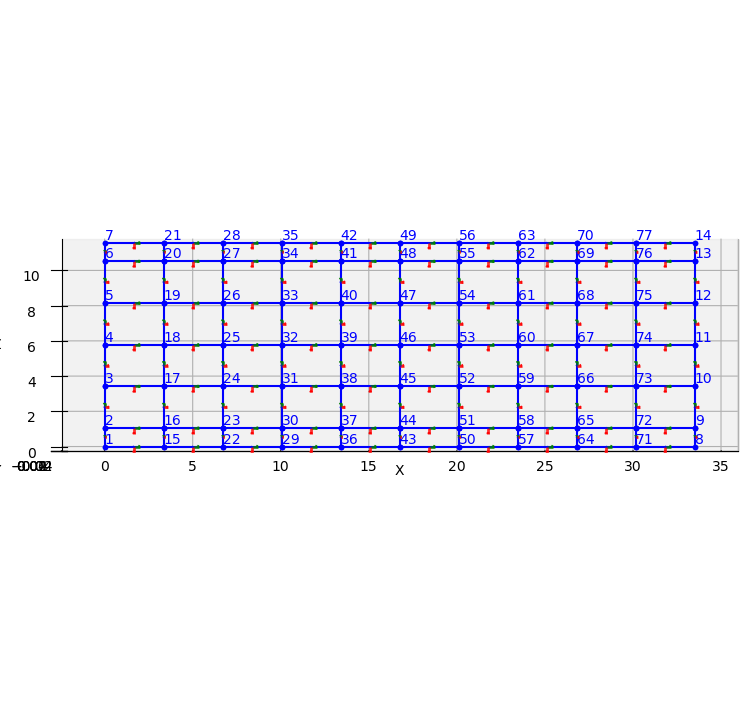

In [22]:
#affichange du modele
og.opsv.plot_model(az_el=(-90, 0),element_labels=0)
fig = og.plt.gcf()
fig.set_size_inches(8, 8)
og.plt.show()

# Chargement

## Poids propre

In [23]:
model.common_grillage_element_z_group



{'edge_beam': [0, 6],
 'exterior_main_beam_1': [1],
 'interior_main_beam': [2, 3, 4],
 'exterior_main_beam_2': [5],
 'start_edge': [0],
 'end_edge': [1, 2],
 'stitch_elements': [0],
 'edge_beam_1': [0],
 'edge_beam_2': [6]}

In [24]:
load_case_data = pd.DataFrame(columns=['name','group','category','relation','type'])
# name =     
# group =     group_name # multiple groups with same category is possible.
# category =  poids-propre,superstructure,gr1a-ts,gr1a-udl,gr1a-pieton-cycliste,gr1b-lm2,gr2-fh,gr3-pieton,gr4-foule,gr5-vs,vent-service,vent-travaux,temperature,neige,chantier
# relation =  ensemble/exclusif/standard
# type =      statique/mobile/dynamique


# create Super T self weight load case 
poidsProprePoutres = og.create_load_case(name="Poids propre poutres")

new_row = {
    'name':     poidsProprePoutres.name,
    'group':    "poids propre",  
    'category': "poids-propre",  
    'relation': "ensemble",  
    'type':     "statique"  
}
load_case_data = pd.concat([load_case_data, pd.DataFrame([new_row])], ignore_index=True)

# poids propre des poutres courantes. 'noz' contient la liste des positions suivant z (axe horizontale transversale) des poutres 
# for i, zPos in enumerate(model.Mesh_obj.noz[:]):  #rappel : si [1:-1] => avec le slicing le '-1' n'est pas inclus. Slicing du tableau des postions Z (transversale) de l'ouvrage
for i in range(len(model.Mesh_obj.noz)):  
    # print(i)
    zPos=model.Mesh_obj.noz[i]
    if i in model.common_grillage_element_z_group['edge_beam']: # ne sert a rien avec [1:-1]
        beamMag = densiteBetonHourdis * sectionPoutreBordure.A # nul jusqu'a ce que j'en decoude du sujet de edge_beam
        memberName = "edge_beam"
        z_group_num_select=0

    elif i in model.common_grillage_element_z_group['exterior_main_beam_1']:
        beamMag = densiteBetonPoutre * sectionPoutreRive.A
        memberName = "exterior_main_beam_1"
        z_group_num_select=0
        
        
    elif i in model.common_grillage_element_z_group['exterior_main_beam_2']:
        beamMag = densiteBetonPoutre * sectionPoutreRive.A
        memberName = "exterior_main_beam_2"
        z_group_num_select=0
        

    #else:
    elif i in model.common_grillage_element_z_group['interior_main_beam']:
        beamMag = densiteBetonPoutre * sectionPoutreCourante.A
        memberName = "interior_main_beam"
        z_group_num_select= int(i-2)
               
    # print(z_group_num_select)
    PoutreElementTags = model.get_element(member = memberName, z_group_num = z_group_num_select, options = "elements") # retrouver l'ensemble des elements beam constituant la poutre nommée # z_group_num=z_group_num_select, : non pertinent
    startNodeTag=ops.eleNodes(PoutreElementTags[0])[0] # recuperer le premier noeud de de premier element beam via la list des tags
    endNodeTag=ops.eleNodes(PoutreElementTags[-1])[-1] # recuperer le dernier (deuxieme ici) noeud de dernier element beam via la list des tags
    startBeam=ops.nodeCoord(startNodeTag)[0] # recuperer la coordonée X du noeud
    endBeam=ops.nodeCoord(endNodeTag)[0] # recuperer la coordonée X du noeud
    
    # PoutreNodes = get_nodes_by_ele_tags(PoutreElementTags)
    # startBeam = PoutreNodes ['X'].iloc[0]
    # endBeam = PoutreNodes ['X'].iloc[-1]
    
    beamLoadBegin = og.create_load_vertex(x=startBeam, z=zPos, p=beamMag)
    beamLoadend = og.create_load_vertex(x=endBeam, z=zPos, p=beamMag)

    selfWeightBeam = og.create_load(loadtype="line", point1=beamLoadBegin, point2=beamLoadend,)

    poidsProprePoutres.add_load(selfWeightBeam)

model.add_load_case(poidsProprePoutres)

# Amelioration  : faire la boucle sur chaque beam element pour pouvoir tenir compte des geometries variables. 
# Pour ce faire, Trouver un moyen de recuperer automatiquement les sections des poutres. Quitte à creer une liste moi meme lors de la definition ou attribution des sections
# creer la charge de la dalle en pente


In [25]:
# FAIRE LA MEME CHOSE POUR LES ENTRETOISE

# create Super T self weight load case 
poidsPropreEntretoise = og.create_load_case(name="Poids propre entretoises")
new_row = {
    'name':     poidsPropreEntretoise.name,
    'group':    "poids propre",  
    'category': "poids-propre",  
    'relation': "ensemble",  
    'type':     "statique"  
}
load_case_data = pd.concat([load_case_data, pd.DataFrame([new_row])], ignore_index=True)

# poids propre des poutres courantes. 'noz' contient la liste des positions suivant z (axe horizontale transversale) des poutres 
for i, xPos in enumerate(model.Mesh_obj.nox[::len(model.Mesh_obj.nox)-1]):  #uniquement le premier et le dernier de la liste

    if i == 0:
        beamMag = densiteBetonHourdis * sectionPoutreEntretoise.A
        memberName = "start_edge"

    elif i == len(model.Mesh_obj.noz[:]) - 1:
        beamMag = densiteBetonHourdis * sectionPoutreEntretoise.A
        memberName = "end_edge"
    else: #je prevois ceci pour au cas ou je fairais des ouvrages à plusieurs travées
        beamMag = densiteBetonHourdis * sectionPoutreEntretoise.A
        memberName = "start_edge"
        
    
    PoutreEntretoiseElementTags = model.get_element(member = memberName, z_group_num = z_group_num_select, options = "elements") # retrouver l'ensemble des elements beam constituant la poutre nommée
    startNodeTag=ops.eleNodes(PoutreEntretoiseElementTags[0])[0] # recuperer le premier noeud de de premier element beam via la list des tags
    endNodeTag=ops.eleNodes(PoutreEntretoiseElementTags[-1])[-1] # recuperer le dernier (deuxieme ici) noeud de dernier element beam via la list des tags
    startBeam=ops.nodeCoord(startNodeTag)[2] # recuperer la coordonée Z du noeud
    endBeam=ops.nodeCoord(endNodeTag)[2] # recuperer la coordonée Z du noeud
    
 
    # PoutreEntretoiseNodes = get_nodes_by_ele_tags(PoutreEntretoiseElementTags)
    # startBeam = PoutreEntretoiseNodes ['X'].iloc[0]
    # endBeam = PoutreEntretoiseNodes ['X'].iloc[-1]
    
    beamLoadBegin = og.create_load_vertex(x=xPos, z=startBeam, p=beamMag)
    beamLoadend = og.create_load_vertex(x=xPos, z=endBeam, p=beamMag)

    selfWeightBeam = og.create_load(loadtype="line", point1=beamLoadBegin, point2=beamLoadend,)

    poidsPropreEntretoise.add_load(selfWeightBeam)

model.add_load_case(poidsPropreEntretoise)

# Amelioration  : faire la boucle sur chaque beam element pour pouvoir tenir compte des geometries variables. 
# Pour ce faire, Trouver un moyen de recuperer automatiquement les sections des poutres. Quitte à creer une liste moi meme lors de la definition ou attribution des sections

In [26]:
# Poids propre du hourdis
overlayMag = densiteBetonHourdis*epaisseurHourdis
x1,z1,x2,z2,x3,z3,x4,z4=coordParallelogramme(0,0,longueurTablier,largeurTablier,angleBiais)

patch_vertex_1 = og.create_load_vertex(x=x1, z=z1, p=overlayMag)
patch_vertex_2 = og.create_load_vertex(x=x2, z=z2, p=overlayMag)
patch_vertex_3 = og.create_load_vertex(x=x3, z=z3, p=overlayMag)
patch_vertex_4 = og.create_load_vertex(x=x4, z=z4, p=overlayMag)
                            
overlaySlab = og.create_load(
    loadtype="patch",
    name="overlay",
    point1=patch_vertex_1,
    point2=patch_vertex_2,
    point3=patch_vertex_3,
    point4=patch_vertex_4,
)

poidsPropreHourdis = og.create_load_case(name="Poids propres hourdis")
new_row = {
    'name':     poidsPropreHourdis.name,
    'group':    "poids propre",  
    'category': "poids-propre",  
    'relation': "ensemble",  
    'type':     "statique"  
}
load_case_data = pd.concat([load_case_data, pd.DataFrame([new_row])], ignore_index=True)

poidsPropreHourdis.add_load(overlaySlab)

model.add_load_case(poidsPropreHourdis)

## Superstructures 

In [27]:

#etencheite
x1,z1,x2,z2,x3,z3,x4,z4=coordParallelogramme(0,largeurTrottoirDroite,longueurTablier,largeurTablier,angleBiais)

etancheiteMagMin = coefEtancheiteMin*densiteEtancheite*epaisseurEtancheite

patch_vertex_1 = og.create_load_vertex(x=x1, z=z1, p=etancheiteMagMin)
patch_vertex_2 = og.create_load_vertex(x=x2, z=z2, p=etancheiteMagMin)
patch_vertex_3 = og.create_load_vertex(x=x3, z=z3, p=etancheiteMagMin)
patch_vertex_4 = og.create_load_vertex(x=x4, z=z4, p=etancheiteMagMin)
                            
etancheiteSurfaciqueMin = og.create_load(
    loadtype="patch",
    name="Etancheite min",
    point1=patch_vertex_1,
    point2=patch_vertex_2,
    point3=patch_vertex_3,
    point4=patch_vertex_4,
)

etancheiteMagMax = coefEtancheiteMax*densiteEtancheite*epaisseurEtancheite

patch_vertex_1 = og.create_load_vertex(x=x1, z=z1, p=etancheiteMagMax)
patch_vertex_2 = og.create_load_vertex(x=x2, z=z2, p=etancheiteMagMax)
patch_vertex_3 = og.create_load_vertex(x=x3, z=z3, p=etancheiteMagMax)
patch_vertex_4 = og.create_load_vertex(x=x4, z=z4, p=etancheiteMagMax)
                            
etancheiteSurfaciqueMax = og.create_load(
    loadtype="patch",
    name="Etancheite max",
    point1=patch_vertex_1,
    point2=patch_vertex_2,
    point3=patch_vertex_3,
    point4=patch_vertex_4,
)


In [28]:

#enrobe
x1,z1,x2,z2,x3,z3,x4,z4=coordParallelogramme(0,largeurTrottoirDroite,longueurTablier,largeurTablier,angleBiais)

enrobeMagMin = coefEnrobeMin*densiteEnrobe*epaisseurEnrobe

patch_vertex_1 = og.create_load_vertex(x=x1, z=z1, p=enrobeMagMin)
patch_vertex_2 = og.create_load_vertex(x=x2, z=z2, p=enrobeMagMin)
patch_vertex_3 = og.create_load_vertex(x=x3, z=z3, p=enrobeMagMin)
patch_vertex_4 = og.create_load_vertex(x=x4, z=z4, p=enrobeMagMin)
                            
enrobeSurfaciqueMin = og.create_load(
    loadtype="patch",
    name="Enrobe min",
    point1=patch_vertex_1,
    point2=patch_vertex_2,
    point3=patch_vertex_3,
    point4=patch_vertex_4,
)

enrobeMagMax = coefEnrobeMax*densiteEnrobe*epaisseurEnrobe

patch_vertex_1 = og.create_load_vertex(x=x1, z=z1, p=enrobeMagMax)
patch_vertex_2 = og.create_load_vertex(x=x2, z=z2, p=enrobeMagMax)
patch_vertex_3 = og.create_load_vertex(x=x3, z=z3, p=enrobeMagMax)
patch_vertex_4 = og.create_load_vertex(x=x4, z=z4, p=enrobeMagMax)
                            
enrobeSurfaciqueMax = og.create_load(
    loadtype="patch",
    name="Enrobe max",
    point1=patch_vertex_1,
    point2=patch_vertex_2,
    point3=patch_vertex_3,
    point4=patch_vertex_4,
)


In [29]:
#trottoir
#gauche
z0=largeurTablier-largeurTrottoirGauche
x0=z0 / math.tan(math.radians(angleBiais)) if angleBiais != 0 else 0
x1,z1,x2,z2,x3,z3,x4,z4=coordParallelogramme(x0,z0,longueurTablier,largeurTrottoirGauche,angleBiais)

trottoirGaucheMagMin = coefTrottoirMin*densiteBetonHourdis*epaisseurTrottoirGauche
patch_vertex_1 = og.create_load_vertex(x=x1, z=z1, p=trottoirGaucheMagMin)
patch_vertex_2 = og.create_load_vertex(x=x2, z=z2, p=trottoirGaucheMagMin)
patch_vertex_3 = og.create_load_vertex(x=x3, z=z3, p=trottoirGaucheMagMin)
patch_vertex_4 = og.create_load_vertex(x=x4, z=z4, p=trottoirGaucheMagMin)
                            
trottoirGaucheSurfaciqueMin = og.create_load(
    loadtype="patch",
    name="Trottoir Gauche min",
    point1=patch_vertex_1,
    point2=patch_vertex_2,
    point3=patch_vertex_3,
    point4=patch_vertex_4,
)

trottoirGaucheMagMax = coefTrottoirMax*densiteBetonHourdis*epaisseurTrottoirGauche
patch_vertex_1 = og.create_load_vertex(x=x1, z=z1, p=trottoirGaucheMagMax)
patch_vertex_2 = og.create_load_vertex(x=x2, z=z2, p=trottoirGaucheMagMax)
patch_vertex_3 = og.create_load_vertex(x=x3, z=z3, p=trottoirGaucheMagMax)
patch_vertex_4 = og.create_load_vertex(x=x4, z=z4, p=trottoirGaucheMagMax)
                            
trottoirGaucheSurfaciqueMax = og.create_load(
    loadtype="patch",
    name="Trottoir Gauche max",
    point1=patch_vertex_1,
    point2=patch_vertex_2,
    point3=patch_vertex_3,
    point4=patch_vertex_4,
)



#droite
z0=0
x0=0
x1,z1,x2,z2,x3,z3,x4,z4=coordParallelogramme(x0,z0,longueurTablier,largeurTrottoirDroite,angleBiais)

trottoirDroiteMagMin = coefTrottoirMin*densiteBetonHourdis*epaisseurTrottoirDroite
patch_vertex_1 = og.create_load_vertex(x=x1, z=z1, p=trottoirDroiteMagMin)
patch_vertex_2 = og.create_load_vertex(x=x2, z=z2, p=trottoirDroiteMagMin)
patch_vertex_3 = og.create_load_vertex(x=x3, z=z3, p=trottoirDroiteMagMin)
patch_vertex_4 = og.create_load_vertex(x=x4, z=z4, p=trottoirDroiteMagMin)
                            
trottoirDroiteSurfaciqueMin = og.create_load(
    loadtype="patch",
    name="Trottoir Droite min",
    point1=patch_vertex_1,
    point2=patch_vertex_2,
    point3=patch_vertex_3,
    point4=patch_vertex_4,
)

trottoirDroiteMagMax = coefTrottoirMax*densiteBetonHourdis*epaisseurTrottoirDroite
patch_vertex_1 = og.create_load_vertex(x=x1, z=z1, p=trottoirDroiteMagMax)
patch_vertex_2 = og.create_load_vertex(x=x2, z=z2, p=trottoirDroiteMagMax)
patch_vertex_3 = og.create_load_vertex(x=x3, z=z3, p=trottoirDroiteMagMax)
patch_vertex_4 = og.create_load_vertex(x=x4, z=z4, p=trottoirDroiteMagMax)
                            
trottoirDroiteSurfaciqueMax = og.create_load(
    loadtype="patch",
    name="Trottoir Droite max",
    point1=patch_vertex_1,
    point2=patch_vertex_2,
    point3=patch_vertex_3,
    point4=patch_vertex_4,
)



In [30]:
# Dispositifs de retenus
#seuls les points 4 et 3 sont utilisés pour les charges lineaires. 4 et 3 pour tenir compte du biais
#gauche
x1,z1,x2,z2,x3,z3,x4,z4=coordParallelogramme(0,0,longueurTablier,largeurTablier-largeurTrottoirGauche,angleBiais)

dispositifRetenuGaucheMagMin = coefDispositifRetenuMin*chargeLineaireDispositifRetenuGauche

patch_vertex_1 = og.create_load_vertex(x=x4,z=z4,p= dispositifRetenuGaucheMagMin)
patch_vertex_2 = og.create_load_vertex(x=x3,z=z3,p= dispositifRetenuGaucheMagMin)

dispositifRetenuGaucheMin = og.create_load(
    loadtype="line", name="Dispositif Retenu Gauche min", point1=patch_vertex_1, point2=patch_vertex_2
)

dispositifRetenuGaucheMagMax = coefDispositifRetenuMax*chargeLineaireDispositifRetenuGauche

patch_vertex_1 = og.create_load_vertex(x=x4,z=z4,p= dispositifRetenuGaucheMagMax)
patch_vertex_2 = og.create_load_vertex(x=x3,z=z3,p= dispositifRetenuGaucheMagMax)

dispositifRetenuGaucheMax = og.create_load(
    loadtype="line", name="Dispositif Retenu Gauche max", point1=patch_vertex_1, point2=patch_vertex_2
)

#droite
x1,z1,x2,z2,x3,z3,x4,z4=coordParallelogramme(0,0,longueurTablier,largeurTrottoirDroite,angleBiais)

dispositifRetenuDroiteMagMin = coefDispositifRetenuMin*chargeLineaireDispositifRetenuDroite

patch_vertex_1 = og.create_load_vertex(x=x4,z=z4,p= dispositifRetenuDroiteMagMin)
patch_vertex_2 = og.create_load_vertex(x=x3,z=z3,p= dispositifRetenuDroiteMagMin)

dispositifRetenuDroiteMin = og.create_load(
    loadtype="line", name="Dispositif Retenu Droite min", point1=patch_vertex_1, point2=patch_vertex_2
)

dispositifRetenuDroiteMagMax = coefDispositifRetenuMax*chargeLineaireDispositifRetenuDroite

patch_vertex_1 = og.create_load_vertex(x=x4,z=z4,p= dispositifRetenuDroiteMagMax)
patch_vertex_2 = og.create_load_vertex(x=x3,z=z3,p= dispositifRetenuDroiteMagMax)

dispositifRetenuDroiteMax = og.create_load(
    loadtype="line", name="Dispositif Retenu Droite max", point1=patch_vertex_1, point2=patch_vertex_2
)

In [31]:
# Gardes corps
#seuls les points 4 et 3 sont utilisés pour les charges lineaires. 4 et 3 pour tenir compte du biais
#gauche
x1,z1,x2,z2,x3,z3,x4,z4=coordParallelogramme(0,0,longueurTablier,largeurTablier-largeurTrottoirGauche,angleBiais)

gardeCorpsGaucheMagMin = coefGardeCorpsMin*chargeLineaireDispositifRetenuGauche

patch_vertex_1 = og.create_load_vertex(x=x4,z=z4,p= gardeCorpsGaucheMagMin)
patch_vertex_2 = og.create_load_vertex(x=x3,z=z3,p= gardeCorpsGaucheMagMin)

gardeCorpsGaucheMin = og.create_load(
    loadtype="line", name="Garde Corps Gauche min", point1=patch_vertex_1, point2=patch_vertex_2
)

gardeCorpsGaucheMagMax = coefGardeCorpsMax*chargeLineaireDispositifRetenuGauche

patch_vertex_1 = og.create_load_vertex(x=x4,z=z4,p= gardeCorpsGaucheMagMax)
patch_vertex_2 = og.create_load_vertex(x=x3,z=z3,p= gardeCorpsGaucheMagMax)

gardeCorpsGaucheMax = og.create_load(
    loadtype="line", name="Garde Corps Gauche max", point1=patch_vertex_1, point2=patch_vertex_2
)



#droite
x1,z1,x2,z2,x3,z3,x4,z4=coordParallelogramme(0,0,longueurTablier,largeurTrottoirDroite,angleBiais)

gardeCorpsDroiteMagMin = coefGardeCorpsMin*chargeLineaireDispositifRetenuDroite

patch_vertex_1 = og.create_load_vertex(x=x4,z=z4,p= gardeCorpsDroiteMagMin)
patch_vertex_2 = og.create_load_vertex(x=x3,z=z3,p= gardeCorpsDroiteMagMin)

gardeCorpsDroiteMin = og.create_load(
    loadtype="line", name="Garde Corps Droite min", point1=patch_vertex_1, point2=patch_vertex_2
)

gardeCorpsDroiteMagMax = coefGardeCorpsMax*chargeLineaireDispositifRetenuDroite

patch_vertex_1 = og.create_load_vertex(x=x4,z=z4,p= gardeCorpsDroiteMagMax)
patch_vertex_2 = og.create_load_vertex(x=x3,z=z3,p= gardeCorpsDroiteMagMax)

gardeCorpsDroiteMax = og.create_load(
    loadtype="line", name="Garde Corps Droite max", point1=patch_vertex_1, point2=patch_vertex_2
)

In [32]:
# Ecrans
#seuls les points 4 et 3 sont utilisés pour les charges lineaires. 4 et 3 pour tenir compte du biais
#gauche
x1,z1,x2,z2,x3,z3,x4,z4=coordParallelogramme(0,0,longueurTablier,largeurTablier,angleBiais)

ecranGaucheMagMin = coefEcranMin*chargeLineaireDispositifRetenuGauche

patch_vertex_1 = og.create_load_vertex(x=x4,z=z4,p= ecranGaucheMagMin)
patch_vertex_2 = og.create_load_vertex(x=x3,z=z3,p= ecranGaucheMagMin)

ecranGaucheMin = og.create_load(
    loadtype="line", name="Ecran Gauche min", point1=patch_vertex_1, point2=patch_vertex_2
)

ecranGaucheMagMax = coefEcranMax*chargeLineaireDispositifRetenuGauche

patch_vertex_1 = og.create_load_vertex(x=x4,z=z4,p= ecranGaucheMagMax)
patch_vertex_2 = og.create_load_vertex(x=x3,z=z3,p= ecranGaucheMagMax)

ecranGaucheMax = og.create_load(
    loadtype="line", name="Ecran Gauche max", point1=patch_vertex_1, point2=patch_vertex_2
)


#droite
x1,z1,x2,z2,x3,z3,x4,z4=coordParallelogramme(0,0,longueurTablier,largeurTrottoirDroite,angleBiais)

ecranDroiteMagMin = coefEcranMin*chargeLineaireDispositifRetenuDroite

#les points 1 et 2 sont considérés ici car la charge doit etre à la rive droite
patch_vertex_1 = og.create_load_vertex(x=x1,z=z1,p= ecranDroiteMagMin)
patch_vertex_2 = og.create_load_vertex(x=x2,z=z2,p= ecranDroiteMagMin)

ecranDroiteMin = og.create_load(
    loadtype="line", name="Ecran Droite min", point1=patch_vertex_1, point2=patch_vertex_2
)

ecranDroiteMagMax = coefEcranMax*chargeLineaireDispositifRetenuDroite

#les points 1 et 2 sont considérés ici car la charge doit etre à la rive droite
patch_vertex_1 = og.create_load_vertex(x=x1,z=z1,p= ecranDroiteMagMax)
patch_vertex_2 = og.create_load_vertex(x=x2,z=z2,p= ecranDroiteMagMax)

ecranDroiteMax = og.create_load(
    loadtype="line", name="Ecran Droite max", point1=patch_vertex_1, point2=patch_vertex_2
)

In [33]:
gmin = og.create_load_case(name="Gmin")
gmin.add_load(etancheiteSurfaciqueMin)
gmin.add_load(enrobeSurfaciqueMin)
gmin.add_load(dispositifRetenuGaucheMin)
gmin.add_load(dispositifRetenuDroiteMin)
gmin.add_load(gardeCorpsGaucheMin)
gmin.add_load(gardeCorpsDroiteMin)
gmin.add_load(ecranGaucheMin)
gmin.add_load(ecranDroiteMin)


new_row = {
    'name':     gmin.name,
    'group':    "superstructure",  
    'category': "superstructure",  
    'relation': "exclusif",  
    'type':     "statique"  
}
load_case_data = pd.concat([load_case_data, pd.DataFrame([new_row])], ignore_index=True)
model.add_load_case(gmin)


gmax = og.create_load_case(name="Gmax")
gmax.add_load(etancheiteSurfaciqueMax)
gmax.add_load(enrobeSurfaciqueMax)
gmax.add_load(dispositifRetenuGaucheMax)
gmax.add_load(dispositifRetenuDroiteMax)
gmax.add_load(gardeCorpsGaucheMax)
gmax.add_load(gardeCorpsDroiteMax)
gmax.add_load(ecranGaucheMax)
gmax.add_load(ecranDroiteMax)

new_row = {
    'name':     gmax.name,
    'group':    "superstructure",  
    'category': "superstructure",  
    'relation': "exclusif",  
    'type':     "statique"  
}
load_case_data = pd.concat([load_case_data, pd.DataFrame([new_row])], ignore_index=True)
model.add_load_case(gmax)

## M1600 national (australie)

In [34]:
# distance between lane edge and axle in z direction 
edge_dist = 0.6 * m  # AS5100

# x and z coordinate of load model origin in global grillage coordinate
x_coord_L1 = 3.5 * m  # As per user requirements
z_coord_L1 = 1.8825 * m  # 1.6 + (11.565-11.000)/2

x_coord_L2 = 3.5 * m
z_coord_L2 = 5.0825 * m  # 1.8825 + 3.2

x_coord_L3 = 3.5 * m
z_coord_L3 = 8.2825 * m  # 1.8825 + 3.2 * 2

x_coord = [x_coord_L1,x_coord_L2,x_coord_L3,]
z_coord = [z_coord_L1,z_coord_L2,z_coord_L3,]

In [35]:
# M1600_load_case = og.create_load_case(name="M1600 notional")
# load_case_list.append(M1600_load_case.name)

In [36]:
udl_line_load = 6 * kN / m
udl_width = 3.2 * m
# M1600 area load
udl_mag = udl_line_load/udl_width

## creation de vehicules

In [37]:
#creer les vehicules
coef_pond_dyn= 1+0.7/(1+0.2*(longueurTravee))

TS1=creerVehicule(TS1_proprietes)
TS2=creerVehicule(TS2_proprietes)
TS3=creerVehicule(TS3_proprietes)

LM2=creerVehicule(LM2_proprietes)
 
MC120=creerVehicule(MC120_proprietes)

TE120=creerVehicule(TE120_proprietes)

PEB=creerVehicule(PEB_proprietes)

C2=creerVehicule(C2_proprietes)

D2F1=creerVehicule(D2F1_proprietes)
D3F1=creerVehicule(D3F1_proprietes)
D3F2=creerVehicule(D3F2_proprietes)

E2F1=creerVehicule(E2F1_proprietes)
E3F1=creerVehicule(E3F1_proprietes)
E3F2=creerVehicule(E3F2_proprietes)

In [38]:
#creerItineraire(vehicule,voie,decalage,pas_vehicule,niveauTablier,longueurTablier, largeurTablier ,largeurTrottoirDroite,largeurTrottoirGauche):
pas_vehicule=1
TS1_itineraire  =creerItineraire(TS1_proprietes   ,"v1" ,0 ,pas_vehicule ,niveauTablier,longueurTablier, largeurTablier ,largeurTrottoirDroite,largeurTrottoirGauche)
TS2_itineraire  =creerItineraire(TS2_proprietes   ,"v2" ,0 ,pas_vehicule ,niveauTablier,longueurTablier, largeurTablier ,largeurTrottoirDroite,largeurTrottoirGauche)
TS3_itineraire  =creerItineraire(TS3_proprietes   ,"v3" ,0 ,pas_vehicule ,niveauTablier,longueurTablier, largeurTablier ,largeurTrottoirDroite,largeurTrottoirGauche)

decalage = ((sum(LM2_proprietes['z'][1:]) + max(LM2_proprietes['b'])) - 3*m)/2 #ne pas inclure le '0' au debut de la list 'z' au cas ou cela devait changer lors des prochaines mise à jour
LM2_itineraire  =creerItineraire(LM2_proprietes   ,"v1" ,decalage ,pas_vehicule ,niveauTablier,longueurTablier, largeurTablier ,largeurTrottoirDroite,largeurTrottoirGauche)
decalage = ((sum(MC120_proprietes['z'][1:]) + max(MC120_proprietes['b'])) - 3*m)/2 + 0.5*m 
MC120_itineraire=creerItineraire(MC120_proprietes ,"v1" ,decalage ,pas_vehicule ,niveauTablier,longueurTablier, largeurTablier ,largeurTrottoirDroite,largeurTrottoirGauche)
decalage = ((sum(TE120_proprietes['z'][1:]) + max(TE120_proprietes['b'])) - 3*m)/2  
TE120_itineraire=creerItineraire(TE120_proprietes ,"v1" ,decalage ,pas_vehicule ,niveauTablier,longueurTablier, largeurTablier ,largeurTrottoirDroite,largeurTrottoirGauche)
decalage = ((sum(PEB_proprietes['z'][1:]) + max(PEB_proprietes['b'])) - 3*m)/2  
PEB_itineraire  =creerItineraire(PEB_proprietes   ,"v1" ,decalage ,pas_vehicule ,niveauTablier,longueurTablier, largeurTablier ,largeurTrottoirDroite,largeurTrottoirGauche)

C2_itineraire   =creerItineraire(C2_proprietes    ,"axe",-0.3 ,pas_vehicule ,niveauTablier,longueurTablier, largeurTablier ,largeurTrottoirDroite,largeurTrottoirGauche)
D2F1_itineraire =creerItineraire(D2F1_proprietes  ,"axe",-0.3 ,pas_vehicule ,niveauTablier,longueurTablier, largeurTablier ,largeurTrottoirDroite,largeurTrottoirGauche)
D3F1_itineraire =creerItineraire(D3F1_proprietes  ,"axe",-0.3 ,pas_vehicule ,niveauTablier,longueurTablier, largeurTablier ,largeurTrottoirDroite,largeurTrottoirGauche)
D3F2_itineraire =creerItineraire(D3F2_proprietes  ,"axe",-0.3 ,pas_vehicule ,niveauTablier,longueurTablier, largeurTablier ,largeurTrottoirDroite,largeurTrottoirGauche)
E2F1_itineraire =creerItineraire(E2F1_proprietes  ,"axe",-0.3 ,pas_vehicule ,niveauTablier,longueurTablier, largeurTablier ,largeurTrottoirDroite,largeurTrottoirGauche)
E3F1_itineraire =creerItineraire(E3F1_proprietes  ,"axe",-0.3 ,pas_vehicule ,niveauTablier,longueurTablier, largeurTablier ,largeurTrottoirDroite,largeurTrottoirGauche)
E3F2_itineraire =creerItineraire(E3F2_proprietes  ,"axe",-0.3 ,pas_vehicule ,niveauTablier,longueurTablier, largeurTablier ,largeurTrottoirDroite,largeurTrottoirGauche )


### M1600 (australie)

In [39]:
alf = [1.0, 0.8, 0.4]
dla = 1.3

In [40]:
M1600_moving_loads = []

In [41]:
gap = 6.25 * m 
m1600_L1_lc = og.create_load_case(name="M1600 L1")
m1600_L2_lc = og.create_load_case(name="M1600 L2")
m1600_L3_lc = og.create_load_case(name="M1600 L3")

# load_case_data.name.append(m1600_L1_lc.name)
# load_case_data.name.append(m1600_L2_lc.name)
# load_case_data.name.append(m1600_L3_lc.name)

new_row = {
    'name':     m1600_L1_lc.name,
    'group':    "LM1-TS1 auxtralie test",  
    'category': "gr1a-ts",  
    'relation': "exclusif",  
    'type':     "statique"  
}
load_case_data = pd.concat([load_case_data, pd.DataFrame([new_row])], ignore_index=True)

new_row = {
    'name':     m1600_L2_lc.name,
    'group':    "LM1-TS1 auxtralie test",  
    'category': "gr1a-ts",  
    'relation': "exclusif",  
    'type':     "statique"  
}
load_case_data = pd.concat([load_case_data, pd.DataFrame([new_row])], ignore_index=True)

new_row = {
    'name':     m1600_L3_lc.name,
    'group':    "LM1-TS1 auxtralie test",  
    'category': "gr1a-ts",  
    'relation': "exclusif",  
    'type':     "statique"  
}
load_case_data = pd.concat([load_case_data, pd.DataFrame([new_row])], ignore_index=True)


m1600_lc_list = [m1600_L1_lc,m1600_L2_lc,m1600_L3_lc]

# For each lane
for i in range(3):
    # Create generic vehicle
    M1600_vehicle_generator = og.create_load_model(model_type="M1600",gap=gap)
    M1600_vehicle_n = M1600_vehicle_generator.create()
    # Position in global coords
    
    M1600_vehicle_n.set_global_coord(og.Point(x_coord[i], 0, z_coord[i]))
    # And add to the load case with the lane factor
    m1600_lc_list[i].add_load(load_obj=M1600_vehicle_n,load_factor=alf[i])
    # And store in list for moving load
    M1600_moving_loads.append(M1600_vehicle_n)
    
    # Now create the patch
    vertex_1 = og.create_load_vertex(x=-longueurTablier, z=z_coord[i] - udl_width/2, p=udl_mag)
    vertex_2 = og.create_load_vertex(x=2*longueurTablier, z=z_coord[i] - udl_width/2, p=udl_mag)
    vertex_3 = og.create_load_vertex(x=2*longueurTablier, z=z_coord[i] + udl_width/2, p=udl_mag)
    vertex_4 = og.create_load_vertex(x=-longueurTablier, z=z_coord[i] + udl_width/2, p=udl_mag)

    M1600_udl = og.create_load(
        loadtype="patch",
        name="M1600 Lane UDL",
        point1=vertex_1,
        point2=vertex_2,
        point3=vertex_3,
        point4=vertex_4,
    )
    m1600_lc_list[i].add_load(load_obj=M1600_udl,load_factor=alf[i])
    model.add_load_case(m1600_lc_list[i],load_factor=dla)
    

In [42]:
start = og.create_point(x=-25,y=0,z=0)
end = og.Point(longueurTablier,0,0)
m1600_path = og.create_moving_path(start_point=start, end_point= end)

In [43]:
# moving_load_list = []
for i in range(3):
    name = f"Moving M1600 L{i+1}"
    moving_m1600 = og.create_moving_load(name=name) 

    
    new_row = {
        'name':     moving_m1600.name,
        'group':    "LM1-TS1 auxtralie",  
        'category': "gr1a-ts",  
        'relation': "exclusif",  
        'type':     "mobile"  
    }
    load_case_data = pd.concat([load_case_data, pd.DataFrame([new_row])], ignore_index=True)
    
    moving_m1600.set_path(m1600_path)
    moving_m1600.add_load(M1600_moving_loads[i])
    model.add_load_case(moving_m1600)
    #add to list for later on
    # moving_load_list.append(moving_m1600)
    
    

In [44]:
# moving_load_list = [] # deja fait pour le vehicule precedent
definirChargeRoulante(TS1,TS1_itineraire,load_case_data,name="TS1 V1",group= "LM1-TS1", category= "gr1a-ts", relation= "exclusif", type="mobile")


# load_case_data.name.extend([load.name for load in moving_load_list])

In [45]:
load_case_data

,name,group,category,relation,type
0,Poids propre poutres,poids propre,poids-propre,ensemble,statique
1,Poids propre entretoises,poids propre,poids-propre,ensemble,statique
2,Poids propres hourdis,poids propre,poids-propre,ensemble,statique
3,Gmin,superstructure,superstructure,exclusif,statique
4,Gmax,superstructure,superstructure,exclusif,statique
5,M1600 L1,LM1-TS1 auxtralie test,gr1a-ts,exclusif,statique
6,M1600 L2,LM1-TS1 auxtralie test,gr1a-ts,exclusif,statique
7,M1600 L3,LM1-TS1 auxtralie test,gr1a-ts,exclusif,statique
8,Moving M1600 L1,LM1-TS1 auxtralie,gr1a-ts,exclusif,mobile
9,Moving M1600 L2,LM1-TS1 auxtralie,gr1a-ts,exclusif,mobile


# Analyse

In [46]:
model.analyze() 

# Resultats

In [47]:
load_list = list(load_case_data.name)
# static_load_list = list(load_case_data[load_case_data.type=="statique"].name)
# moving_load_list = list(load_case_data[load_case_data.type=="mobile"].name)

global_result = model.get_results()
# static_lc_result = model.get_results(load_case=static_load_list) 
# moving_lc_result = model.get_results(load_case=moving_load_list)
# moving_lc_result

## Cas unitaires

In [48]:
# model.common_grillage_element_z_group
# {'edge_beam': [0, 6],
#  'exterior_main_beam_1': [1],
#  'interior_main_beam': [2, 3, 4],
#  'exterior_main_beam_2': [5],
#  'start_edge': [0],
#  'end_edge': [1, 2],
#  'stitch_elements': [0],
#  'edge_beam_1': [0],
#  'edge_beam_2': [6]}

global_result

<xarray.Dataset>
Dimensions:        (Loadcase: 194, Node: 77, Component: 18, Element: 136,
                    Nodes: 2)
Coordinates:
  * Loadcase       (Loadcase) <U53 'Poids propre poutres' ... 'TS1 V1 at glob...
  * Node           (Node) int32 1 2 3 4 5 6 7 8 9 ... 69 70 71 72 73 74 75 76 77
  * Component      (Component) <U7 'Mx_i' 'Mx_j' 'My_i' ... 'theta_y' 'theta_z'
  * Element        (Element) int32 1 2 3 4 5 6 7 ... 130 131 132 133 134 135 136
  * Nodes          (Nodes) <U1 'i' 'j'
Data variables:
    displacements  (Loadcase, Node, Component) object nan ... -3.598235664605...
    forces         (Loadcase, Element, Component) object -118495.35005746692 ...
    ele_nodes      (Element, Nodes) object 1 2 2 3 3 4 4 ... 75 12 76 13 77 14

In [49]:

load_case_name  = 'Gmin'
member_name = "interior_main_beam"
z_group_index = 2
force_components = ['Mz', 'Vy']

combined_values = get_forces_per_beam_per_lc(global_result,load_case_name= load_case_name, member_name = member_name, z_group_index = z_group_index, force_components =force_components)
combined_values

# faire une boucle pour toute les cas de charges pour toutes les files de poutres

,Node,X_Coord,Gmin : Mz,Gmin : Vy
0,5.0,0.00,2.04,-38.36
1,19.0,3.35,140.50,-56.95
2,26.0,6.70,335.16,-46.17
3,33.0,10.05,490.99,-27.98
4,40.0,13.40,585.04,-9.34
5,47.0,16.75,616.35,9.03
6,54.0,20.10,585.83,27.73
7,61.0,23.45,491.82,46.06
8,68.0,26.80,333.68,57.17
9,75.0,30.15,132.15,38.83


## Combinaisions

In [50]:
# export excel of LC

# load_list_combis = list(global_result.Loadcase.to_numpy())
# combis = pd.DataFrame(columns=['Combinaison'] + load_list_combis) # 'Type de Combinaison', : in pactera la trasformation de des combis en dict
# combis.to_excel('combinaisons.xlsx', index=False)




# Exemple de données
load_list_combis = list(global_result.Loadcase.to_numpy())
combis = pd.DataFrame(columns=['Combinaison'] + load_list_combis)

# Chemin du fichier
file_path = 'combinaisons.xlsx'

# Vérification si le fichier existe
if os.path.exists(file_path):
    user_input = input(f"Le fichier '{file_path}' existe déjà. Voulez-vous l'utiliser ? (oui/non) : ").strip().lower()
    if user_input == 'oui':
        print(f"Utilisation du fichier existant : {file_path}")
    else:
        print("Vous avez choisi de ne pas utiliser le fichier existant.")
else:
    # Création du fichier Excel si non existant
    combis.to_excel(file_path, index=False)
    print(f"Fichier créé : {file_path}")


Utilisation du fichier existant : combinaisons.xlsx


In [51]:
combis = pd.read_excel('combinaisons.xlsx')
combis.head()

,Combinaison,Poids propre poutres,Poids propre entretoises,Poids propres hourdis,Gmin,Gmax,M1600 L1,M1600 L2,M1600 L3,"Moving M1600 L1 at global position [-25.00,0.00,0.00]",...,"TS1 V1 at global position [24.47,0.00,2.50]","TS1 V1 at global position [25.48,0.00,2.50]","TS1 V1 at global position [26.48,0.00,2.50]","TS1 V1 at global position [27.48,0.00,2.50]","TS1 V1 at global position [28.49,0.00,2.50]","TS1 V1 at global position [29.49,0.00,2.50]","TS1 V1 at global position [30.49,0.00,2.50]","TS1 V1 at global position [31.49,0.00,2.50]","TS1 V1 at global position [32.50,0.00,2.50]","TS1 V1 at global position [33.50,0.00,2.50]"
0,ELS QP 100,1,1,1,1,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ELS CARA 100,1,1,1,1,1,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ELS CARA 101,1,1,1,1,1,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ELS CARA 102,1,1,1,1,1,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ELS CARA 103,1,1,1,1,1,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
# envellope min max des groupe de combi : ELS QP,ELS CARA etc (groupage automatique par code)
member_name = "interior_main_beam"
z_group_index = 2
force_components = ['Mz', 'Vy']
get_forces_per_beam_per_comb_group(combis=combis.iloc[0:2,:], member_name  = member_name, z_group_index  = z_group_index, force_components  = force_components)


,Node,X_Coord,combi : Mz_max,combi : Vy_max,combi : Mz_min,combi : Vy_min
0,5.0,0.00,10.42,0.00,5.00,-595.12
1,19.0,3.35,2055.13,3.35,19.00,-592.96
2,26.0,6.70,4063.42,6.70,26.00,-447.27
3,33.0,10.05,5571.43,10.05,33.00,-268.65
4,40.0,13.40,6475.18,13.40,40.00,-87.49
5,47.0,16.75,6767.16,92.15,47.00,16.75
6,54.0,20.10,6452.70,270.79,54.00,20.10
7,61.0,23.45,5534.83,445.68,61.00,23.45
8,68.0,26.80,4020.58,589.04,68.00,26.80
9,75.0,30.15,1998.42,593.55,75.00,30.15


# Appuis

In [73]:
# Retrieve nodes from the model
nodes = model.get_nodes()  # Assuming this returns a dictionary of dictionaries

# Extract node tags
nodes_tags = {node_id: data['tag'] for node_id, data in nodes.items() if 'tag' in data}

# Loop through node tags and apply the 'fix' command
for node_tag in nodes_tags.values():
    ops.fix(node_tag, 0, 0, 0, 0, 0, 0)  # Unconstrain all DOFs




In [74]:
model.analyze()

In [75]:
member_name = "interior_main_beam"
z_group_index = 2
force_components = ['Mz', 'Vy']
get_forces_per_beam_per_comb_group(combis=combis.iloc[0:2,:], member_name  = member_name, z_group_index  = z_group_index, force_components  = force_components)

,Node,X_Coord,combi : Mz_max,combi : Vy_max,combi : Mz_min,combi : Vy_min
0,5.0,0.00,10.42,0.00,5.00,-595.12
1,19.0,3.35,2055.13,3.35,19.00,-592.96
2,26.0,6.70,4063.42,6.70,26.00,-447.27
3,33.0,10.05,5571.43,10.05,33.00,-268.65
4,40.0,13.40,6475.18,13.40,40.00,-87.49
5,47.0,16.75,6767.16,92.15,47.00,16.75
6,54.0,20.10,6452.70,270.79,54.00,20.10
7,61.0,23.45,5534.83,445.68,61.00,23.45
8,68.0,26.80,4020.58,589.04,68.00,26.80
9,75.0,30.15,1998.42,593.55,75.00,30.15


# Mise à jour de ospgrillage : 
- members.py : Creer des GrillageMember entretoise : a creer au choix par l'utilisateur. Entrtoise relier par des liens aux extremité des poteaux
- osp_grillage.py : creer une fonction pour definir les appuis. la function _write_op_fix (executé dans _run_mesh_generation) sera executé que si aucun appuis defini par l'utilisateur
- postprocessing : recuperer les reactions d'appuis dans un Xarray

Autres
- multiple travée (penser à regrouper les files de poutres sivant ce qui est deja défini)
- biais

# Garbage

# Ancien modele

## Creation des appuis

In [ ]:

for i in range(len(xAppuis)): 
    entretoiseTag=int((round(poutreTag/100,0)*100*10)+100*(i-1)) 
    for j,yPoint in enumerate(yPoutresTablierAA):#j commence à 0  
        if (yPoint in yAA):
            
            nodeTag=100*(i+1)+(j)
            nodeFixity = (nodeTag,) + appuiAAPile #Pre-append nodeTag to fixity tuple 
            ops.fix(*nodeFixity) #Unpack nodeFixity contents into argument for 'fix' method
            

     #faire une boucle pour que les appuis des culees soit differentes de celles des piles


In [ ]:
plotStructure('Poutres et entretoise')

## Affichage des chargements

In [ ]:
'''
#Define a new function to plot loads
def plotLoads(title):
    opsv.plot_loads_3d(sfac=True, fig_wi_he=(50,20))
    plt.title(title)
    plt.xlabel('Distance (m)')
    plt.ylabel('Distance (m)')
    plt.grid()
    plt.show()

plotStructure('Structure')
plotLoads('Structure et chargement')
'''

## Analyse

In [ ]:
#ops.record()

ops.system('BandGeneral')# Create SOE # BandGeneral more general solver than 'BandSPD'
ops.numberer('RCM')# Create DOF number
ops.constraints('Transformation')# Create constraint handler
ops.integrator('LoadControl', 1)# Create integrator
ops.algorithm('Linear')# Create algorithm
ops.analysis('Static')# Create analysis object
ops.analyze(1)# Perform the analysis (with 1 analysis step)
result = ops.analyze(1)
if result != 0:
    print("Echec de l'analyse")
else:
    print("Analyse reussie")
    
#ops.printModel() #model data

## Deformation

In [ ]:

def process_static_forces(static_lc_result, load_case_name, member_name, z_group_index, force_components):
    """
    Process force components for a given member and load case.

    Parameters:
        static_lc_result: xarray dataset containing force results.
        load_case_name (str): Load case to process.
        member_name (str): Name of the member to process.
        z_group_index (int): Index for the Z group.
        force_components (list): List of force components (e.g., ['Mz', 'Vy']).

    Returns:
        pd.DataFrame: Combined values with node tags and X coordinates.
    """
    # Convert load_case_name to a list for selection
    load_case_name = [load_case_name]

    # Get elements for the member
    poutre_elements = model.get_element(member=member_name, z_group_num=z_group_index, options="elements")

    # Prepare force component names for i and j
    force_component_i = [f"{component}_i" for component in force_components]
    force_component_j = [f"{component}_j" for component in force_components]

    # Get i and j values
    i_values = np.round(
        static_lc_result.forces.sel(
            Loadcase=load_case_name, Component=force_component_i, Element=poutre_elements
        ).values.astype(np.float64) / 1000,
        2
    )

    j_values = -1 * np.round(
        static_lc_result.forces.sel(
            Loadcase=load_case_name, Component=force_component_j, Element=poutre_elements
        ).values.astype(np.float64)[:, -1] / 1000,
        2
    )

    # Reshape j_values to match dimensions and concatenate
    j_values_reshaped = j_values.reshape(i_values.shape[0], 1, -1)
    combined_values = np.concatenate((i_values, j_values_reshaped), axis=1)

    # Get node tags and X coordinates
    poutre_nodes = get_nodes_by_ele_tags(poutre_elements)
    x_values = poutre_nodes.to_numpy()[:, :2]

    # Reshape x_values and concatenate along the third dimension
    x_values_reshaped = np.tile(x_values, (i_values.shape[0], 1, 1))
    combined_with_x = np.concatenate((x_values_reshaped, combined_values), axis=2)

    # Flatten the 3D array to 2D
    reshaped_array = combined_with_x.reshape(combined_with_x.shape[1], combined_with_x.shape[2])
    
    # Base column names
    column_names = ['Node', 'X_Coord']

    force_column_names = force_components
    # # Generate _Mz and _Vy column names for each load case # this dunction only take one load_case
    # force_column_names = [f"{load_case} : Mz" for load_case in load_case_name] + \
    #                     [f"{load_case} : Vy" for load_case in load_case_name]

    # Combine the base column names with the force column names
    column_names.extend(force_column_names)     

    df = pd.DataFrame(reshaped_array, columns=column_names)
    
    return df


load_case_name  = "Gmax" #,'M1600 L1','M1600 L2', 'M1600 L3']
member_name = "interior_main_beam"
z_group_index = 2
force_components = ['Mz', 'Vy']
combined_values = process_static_forces(static_lc_result,load_case_name, member_name, z_group_index, force_components)

# Print results
print("Combined Values Shape:", combined_values.shape)
combined_values